## Data Loading and Preprocessing
- Build Tokenizer, Vocab, Encoder and Decoder Functions

In [1]:
from datasets import load_dataset

dataset = load_dataset("roneneldan/TinyStories")

train_text = dataset['train']['text']
val_text = dataset['validation']['text']

del dataset

import json

with open("train_data.json", 'w') as file:
    json.dump(train_text, file)

with open("val_data.json", 'w') as file:
    json.dump(val_text, file)

c:\Users\rajna\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Repo card metadata block was not found. Setting CardData to empty.
Generating train split: 2119719 examples [00:02, 788965.38 examples/s]
Generating validation split: 21990 examples [00:00, 510009.93 examples/s]


In [1]:
import json
with open("train_data.json", "r") as f:
    train_text = json.load(f)

In [2]:
vocab = set()
for text in train_text:
    vocab.update(text)

print(len(vocab))

174


In [3]:
EOS_TOKEN = "<EOS>" ## End Of Story
PAD_TOKEN = "<PAD>" ## Padding

decode_vocab = list(vocab)
decode_vocab.sort()
decode_vocab.append(EOS_TOKEN)
decode_vocab.append(PAD_TOKEN)
encode_vocab = {text: idx for idx, text in enumerate(decode_vocab)}

: 

In [2]:
def encode(text):
    # text += EOS_TOKEN
    # n = len(text)
    # idx = 0
    # encoded_text = []
    # while idx < n:
    #     jdx = n
    #     while jdx > idx and text[idx:jdx] not in encode_vocab:
    #         jdx -= 1
    #     token = text[idx:jdx]
    #     encoded_text.append(encode_vocab[token])
    #     idx = jdx
    # return encoded_text

    tokens = [encode_vocab[token] for token in text]
    tokens.append(encode_vocab[EOS_TOKEN])

    while True:
        encoded_text = []
        idx = 0
        while idx < len(tokens):
            if tokens[idx] == encode_vocab[EOS_TOKEN]:
                encoded_text.append(tokens[idx])
                idx += 1
            else:
                try:
                    new_token = encode_vocab[decode(tokens[idx: idx + 2])]
                    encoded_text.append(new_token)
                    idx += 2
                except:
                    encoded_text.append(tokens[idx])
                    idx += 1
        
        if len(encoded_text) >= len(tokens): return encoded_text
        tokens = encoded_text

def decode(encoded_text):
    return "".join([decode_vocab[idx] for idx in encoded_text])


# decode(encode(train_text[0])) == train_text[0] + EOS_TOKEN

<BarContainer object of 4035 artists>

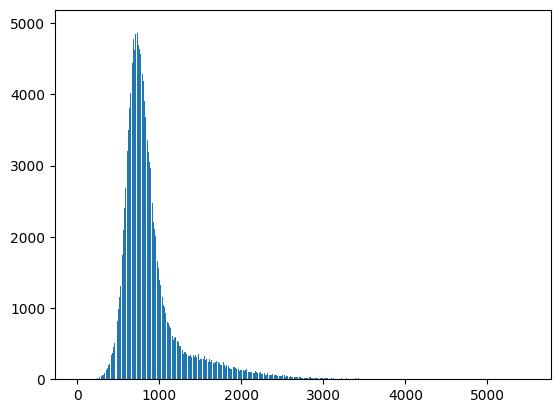

In [5]:
from collections import Counter
import matplotlib.pyplot as plt

dist = Counter([len(text) for text in train_text])
plt.bar(dist.keys(), dist.values())

In [6]:
len(train_text)

2119719

In [7]:
# from tqdm import tqdm
# freq_dist = Counter()

# for text in train_text:
#     tokens = encode(text)
#     for idx in range(len(tokens) - 1):
#         freq_dist[(tokens[idx], tokens[idx + 1])] += 1

# with tqdm(total=len(train_text), desc="Processing texts") as pbar:
#     for text in train_text:
#         tokens = encode(text)
#         for idx in range(len(tokens) - 1):
#             freq_dist[(tokens[idx], tokens[idx + 1])] += 1
#         pbar.update(1)


## SOmehow not working --> No process in tqdm --> Issue was with jupyter kernel, it works with .py file
## Windows Defender is blocking the process
## Tried excluding as well but not working
## Tried turning off real time protection but not working


# from multiprocessing import Pool
# from tqdm import tqdm

# def process_text(text):
#     tokens = encode(text) 
#     freq_dist = Counter()
#     for idx in range(len(tokens) - 1): freq_dist[(tokens[idx], tokens[idx + 1])] += 1
#     return freq_dist

# final_freq_dist = Counter()

# with Pool(processes = 16) as pool:
#     for partial_freq_dist in tqdm(pool.imap_unordered(process_text, train_text[:100_000]), total=100_000, desc="Processing texts"):
#         final_freq_dist.update(partial_freq_dist)

In [8]:
## Ideally we should update the most frequent pairs in one iteration. But that'll take too mcuh time for learning
## Maybe after learninng BPE, I can just import GPT2 tokenizer and carry on with model definition and training

# for (elem, freq) in freq_dist.most_common(100):
#     text = decode(elem)
#     decode_vocab.append(text)
#     encode_vocab[text] = len(decode_vocab) - 1

In [18]:
from tqdm import tqdm

def get_freq_dist(corpus):
    freq_dist = Counter()
    with tqdm(total=len(corpus), desc="Processing texts") as pbar:
        for text in corpus:
            tokens = encode(text)
            for idx in range(len(tokens) - 1):
                freq_dist[(tokens[idx], tokens[idx + 1])] += 1
            pbar.update(1)
    
    return freq_dist

# def update_vocab(freq_dist, num_updates):
#     for (elem, freq) in freq_dist.most_common(num_updates):
#         text = decode(elem)
#         decode_vocab.append(text)
#         encode_vocab[text] = len(decode_vocab) - 1


def update_vocab(freq_dist):
    most_common_freq = freq_dist.most_common(1)[0][1]
    for (elem, freq) in freq_dist.most_common():
        if freq < most_common_freq * 0.9 or len(decode_vocab) == VOCAB_SIZE: break
        text = decode(elem)
        encode_vocab[text] = len(decode_vocab)
        decode_vocab.append(text)

In [1]:
# from multiprocessing import Pool

# final_freq_dist = Counter()
# with Pool(processes = 4) as pool:
#     for partial_freq_dist in pool.imap_unordered(get_freq_dist, train_text):
#         final_freq_dist.update(partial_freq_dist)

# update_vocab(final_freq_dist)

NameError: name 'Counter' is not defined

In [17]:
VOCAB_SIZE = 512
num_iters = 0
while len(decode_vocab) < VOCAB_SIZE:
    num_iters += 1
    freq_dist = get_freq_dist(train_text)
    update_vocab(freq_dist)
    print(f"iteration: {iter}, vocab_size: {len(decode_vocab)}")

Processing texts:   4%|▎         | 76548/2119719 [00:52<23:10, 1469.24it/s]


KeyboardInterrupt: 

In [11]:
import json

PAD_TOKEN = "<PAD>"
decode_vocab.append(PAD_TOKEN)
encode_vocab[PAD_TOKEN] = len(decode_vocab) - 1

with open("vocab_v2.json", "w") as f:
    json.dump(decode_vocab, f)

In [12]:
print(decode_vocab[-100:])

['little', 'Once up', 'e upon a', 'on a tim', 'One day, ', ' time, ther', 'e, there was a ', ' girl ', '."\n\n', 'hing', 'Mom', ' it', '. \n\n', 'ear', 'ill ', 'ep', ' are', 'elt ', ' som', ' so ', ' to', "n't ", 'care', 'um', 'd the ', 'named ', 'out ', 'le gir', ' very ', 'hen ', 'â€', 'sp', 'some', 'ter ', ' happ', ', and ', 'new', 'ful ', ' that ', 'oy ', ' saw', ' were ', 'ome ', ' him', 'che', 'loo', 'friend', 'ran', ' have', 'a b', '," ', 'e to', 'ed the', 'y with ', 'ain', 'bo', ' they ', 'now', 'ed and', 'ju', 'ok', ' and s', 'they', 'ying ', 'big ', ' was s', 'hou', 'ade ', ' is ', 'do', ' did', ' love', 'ud', 'man', 'use', 'smil', 'ys ', 'dde', ' ne', '\n\nThe ', 'low', 'old ', ' to the ', 'am', 'cit', 'y to', 'day', ' can', 'he was', '.\n\nThe ', 'are ', ' hel', 'ter', 's. They', ' and ', 'king ', 'e. T', 'nn', ' in the ', 'y. She']


## Data_Loader
- Gets a batch of train texts

In [3]:
with open("vocab.json", "r") as f:
    decode_vocab = json.load(f)

encode_vocab = {text: idx for idx, text in enumerate(decode_vocab)}

In [4]:
CONTEXT_LENGTH = 256
MAX_LEN = max([len(text) for text in train_text])
VOCAB_SIZE = len(decode_vocab)

In [5]:
import numpy as np
import torch

def get_batch(corpus, batch_size):
    random_story_indexes = np.random.randint(0, len(corpus), batch_size)
    X = []
    y = []
    for idx in random_story_indexes:
        story = corpus[idx]
        story = encode(story)
        if len(story) <= (CONTEXT_LENGTH + 1):
            story += [encode_vocab[PAD_TOKEN]] * (CONTEXT_LENGTH + 1 - len(story))
            jdx = 0
        else:
            jdx = np.random.randint(0, len(story) - (CONTEXT_LENGTH + 1))
        X.append(story[jdx: jdx + CONTEXT_LENGTH])
        y.append(story[jdx + 1: jdx + CONTEXT_LENGTH + 1])
    
    return torch.Tensor(X).long(), torch.Tensor(y).long()

# x, y = get_batch(train_text, 1)
# print(decode(x[0]))
# print('-'*50)
# print(decode(y[0]))

## Define Model
    - Input Language Encoding Layer
    - Positional Encoding Layer
    - Masked Scaled Dot Product Attention --> Masked Multi Head Attention -> Multi Head Attention
    - Decoder class
    - Decoder Layer
    - GPT Layer

In [6]:
import torch.nn as nn

In [7]:
EMBEDDING_DIM = 128
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
def positional_encoding(context_length, embedding_dim):
    pos = np.arange(context_length).reshape(-1, 1)
    i = np.arange(embedding_dim).reshape(1, -1)
    angle = pos / np.power(10000, 2 * i / embedding_dim)
    angle[:, 0::2] = np.sin(angle[:, 0::2])
    angle[:, 1::2] = np.cos(angle[:, 1::2])
    return torch.Tensor(angle)

In [20]:
## Scaled dot product attention
## d_model = d_k = d_v ==> number of queries, keys and values
## Always the same mistake: X is of shape (B, context_len, EMbedding_Dim) but that is only true while training. 
## We do give smaller context length while testing or generating text
## So, we need to make sure that the model is able to handle that as well. Mask will be used for that purpose [:T, :T]

## Masking also helps turn 

class attention_head(nn.Module):
    def __init__(self, d_model, dropout = 0.1):
        super().__init__()

        self.d_model = d_model
        self.K = nn.Linear(in_features = EMBEDDING_DIM, out_features = d_model, bias=False)
        self.Q = nn.Linear(in_features = EMBEDDING_DIM, out_features = d_model, bias=False)
        self.V = nn.Linear(in_features = EMBEDDING_DIM, out_features = d_model, bias=False)
        self.register_buffer('mask', torch.tril(torch.ones(CONTEXT_LENGTH, CONTEXT_LENGTH)))
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.Softmax(dim = -1)

    def forward(self, x):
        B, T, _ = x.shape
        Q = self.Q(x)
        K = self.K(x)
        V = self.V(x)

        attention_scores = Q @ K.transpose(-2, -1) ## Q -> (B, L, d_model), K -> (B, d_model, L) => K.transpose(-2, -1) -> (B, L, d_model) => Q @ K.transpose(-2, -1) -> (B, L, L)
        attention_scores /= np.sqrt(self.d_model)
        attention_scores = attention_scores.masked_fill(self.mask[:T, :T] == 0, -1e9)
        attention_scores = self.softmax(attention_scores) ## (B, L, L) -> (B, L, L)
        attention_scores = self.dropout(attention_scores)
        attention = attention_scores @ V ## (B, L, L) @ (B, L, d_model) -> (B, L, d_model)

        return attention ## (B, L, d_model)
    
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, d_model, dropout = 0.1):
        super().__init__()

        self.heads = nn.ModuleList([attention_head(d_model, dropout) for _ in range(num_heads)])
        self.linear = nn.Linear(in_features = num_heads * d_model, out_features = d_model)

    def forward(self, x):
        ## x -> (B, L, EMBEDDING_DIM)
        attention = torch.cat([head(x) for head in self.heads], dim = -1) ## (B, L, num_heads * d_model)
        return self.linear(attention) ## (B, L, d_model)
    

class DecoderBlock(nn.Module):
    def __init__(self, num_heads, d_model, dropout = 0.1):
        super().__init__()

        self.multi_head_attention = MultiHeadAttention(num_heads, d_model, dropout) 
        self.norm1 = nn.LayerNorm(d_model)
        self.feed_forward = nn.Sequential(
            nn.Linear(in_features = d_model, out_features = 4 * d_model),
            nn.ReLU(),
            nn.Linear(in_features = 4 * d_model, out_features = d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        ## x -> (B, L, EMBEDDING_DIM)
        attention = self.multi_head_attention(x) ## (B, L, d_model)
        x = self.norm1(x + attention) ## (B, L, d_model)
        feed_forward = self.feed_forward(x) ## (B, L, d_model)
        return self.norm2(x + feed_forward) ## (B, L, d_model)
    
class Decoder_layer(nn.Module):
    def __init__(self, num_heads, d_model, num_layers = 6, dropout = 0.1):
        super().__init__()

        self.blocks = nn.ModuleList([DecoderBlock(num_heads, d_model, dropout) for _ in range(num_layers)])

    def forward(self, x):
        ## x -> (B, L, EMBEDDING_DIM)
        for block in self.blocks:
            x = block(x)
        return x ## (B, L, d_model)
    
class Model(nn.Module):
    def __init__(self, num_heads, d_model, vocab_size, dropout = 0.1):
        super().__init__()

        self.lang_embedding = nn.Embedding(num_embeddings = vocab_size, embedding_dim = EMBEDDING_DIM)
        self.decoder = Decoder_layer(num_heads, d_model, 3, dropout) 
        self.linear = nn.Linear(in_features = d_model, out_features = vocab_size)
        self.softmax = nn.Softmax(dim = -1)

    def forward(self, x):
        ## x -> (B, L)
        x = self.lang_embedding(x) ## (B, L, EMBEDDING_DIM)
        x += positional_encoding(x.shape[1], x.shape[2]).to(DEVICE)
        x = self.decoder(x) ## (B, L, d_model)
        x = self.linear(x) ## (B, L, vocab_size)
        return self.softmax(x) ## (B, L, vocab_size)

In [21]:
## Define loss function for the model
## The model ouputs a probability distribution over the vocabulary
## We can use cross entropy loss to calculate the loss

model = Model(num_heads=8, d_model = 128, vocab_size = VOCAB_SIZE, dropout=0.3).to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [22]:
NUM_EPOCHS = 1
BATCH_SIZE = 256
NO_OF_BATCHES = len(train_text) // BATCH_SIZE
losses = []

In [23]:
EOS_TOKEN = "<EOS>"
PAD_TOKEN = "<PAD>"

In [24]:
for epoch in range(NUM_EPOCHS):
    for batch in range(NO_OF_BATCHES):
        X, y = get_batch(train_text, BATCH_SIZE)
        X, y = X.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred.view(-1, VOCAB_SIZE), y.view(-1))
        loss.backward()
        optimizer.step()

        if batch % 1000 == 0:
            print(f"Epoch: {batch}, Loss: {loss.item()}")
            losses.append(loss.item())

Epoch: 0, Loss: 6.356118679046631


KeyboardInterrupt: 

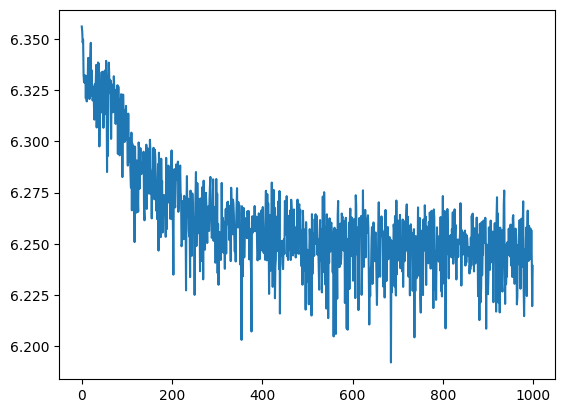

In [180]:
plt.plot(losses)

In [ ]:
def generate_text(model, context, length = 256):
    model.eval()
    with torch.no_grad():
        context = encode(context)
        context = context[:-1]
        context = torch.Tensor(context).long().to(DEVICE)
        for _ in range(length):
            y_pred = model(context.unsqueeze(0)[:,-CONTEXT_LENGTH:])
            # next_token = torch.multinomial(y_pred[0, -1], 1).item()
            next_token = torch.argmax(y_pred[0, -1]).item()
            context = torch.cat([context, torch.Tensor([next_token]).long().to(DEVICE)])
    
    return decode(context)

In [184]:
generate_text(model, "Once upon a time")

torch.Size([1, 3, 576])
torch.Size([1, 4, 576])
torch.Size([1, 5, 576])
torch.Size([1, 6, 576])
torch.Size([1, 7, 576])
torch.Size([1, 8, 576])
torch.Size([1, 9, 576])
torch.Size([1, 10, 576])
torch.Size([1, 11, 576])
torch.Size([1, 12, 576])
torch.Size([1, 13, 576])
torch.Size([1, 14, 576])
torch.Size([1, 15, 576])
torch.Size([1, 16, 576])
torch.Size([1, 17, 576])
torch.Size([1, 18, 576])
torch.Size([1, 19, 576])
torch.Size([1, 20, 576])
torch.Size([1, 21, 576])
torch.Size([1, 22, 576])
torch.Size([1, 23, 576])
torch.Size([1, 24, 576])
torch.Size([1, 25, 576])
torch.Size([1, 26, 576])
torch.Size([1, 27, 576])
torch.Size([1, 28, 576])
torch.Size([1, 29, 576])
torch.Size([1, 30, 576])
torch.Size([1, 31, 576])
torch.Size([1, 32, 576])
torch.Size([1, 33, 576])
torch.Size([1, 34, 576])
torch.Size([1, 35, 576])
torch.Size([1, 36, 576])
torch.Size([1, 37, 576])
torch.Size([1, 38, 576])
torch.Size([1, 39, 576])
torch.Size([1, 40, 576])
torch.Size([1, 41, 576])
torch.Size([1, 42, 576])
torch.S

'Once upon a timee wn, wn, wn, wn, w as, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn, wn'

In [ ]:
# for param_group in optimizer.param_groups:
#     param_group['lr'] = 1e-4

# model_path = 'my_model_state_dict.pth'
# torch.save(model.state_dict(), model_path)


# # Assuming you have the same model architecture as before
# loaded_model = model()  # Instantiate your model class
# loaded_model.load_state_dict(torch.load(model_path))
# loaded_model.eval()  # Set the model to evaluation mode